In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Widget
from enum import Enum
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Default values
l_o = 0.05
h_o = 0.00001
h_pcb = 0.0001

# Bending angles to perform further calculations for
# Has to be symmetrical around 0
samples = 360
limit = np.pi/4
r = np.linspace(-limit, limit, samples, dtype=np.float128)
print(r)
#lengths = np.arange(0.005, 0.1, 0.005)
#grid = np.meshgrid(lengths, r)
#print(r)
#plt.plot(r, r)
#plt.show()

[-0.78539816 -0.78102269 -0.77664721 -0.77227173 -0.76789625 -0.76352078
 -0.7591453  -0.75476982 -0.75039435 -0.74601887 -0.74164339 -0.73726791
 -0.73289244 -0.72851696 -0.72414148 -0.719766   -0.71539053 -0.71101505
 -0.70663957 -0.7022641  -0.69788862 -0.69351314 -0.68913766 -0.68476219
 -0.68038671 -0.67601123 -0.67163576 -0.66726028 -0.6628848  -0.65850932
 -0.65413385 -0.64975837 -0.64538289 -0.64100741 -0.63663194 -0.63225646
 -0.62788098 -0.62350551 -0.61913003 -0.61475455 -0.61037907 -0.6060036
 -0.60162812 -0.59725264 -0.59287717 -0.58850169 -0.58412621 -0.57975073
 -0.57537526 -0.57099978 -0.5666243  -0.56224882 -0.55787335 -0.55349787
 -0.54912239 -0.54474692 -0.54037144 -0.53599596 -0.53162048 -0.52724501
 -0.52286953 -0.51849405 -0.51411857 -0.5097431  -0.50536762 -0.50099214
 -0.49661667 -0.49224119 -0.48786571 -0.48349023 -0.47911476 -0.47473928
 -0.4703638  -0.46598833 -0.46161285 -0.45723737 -0.45286189 -0.44848642
 -0.44411094 -0.43973546 -0.43535998 -0.43098451 -0.

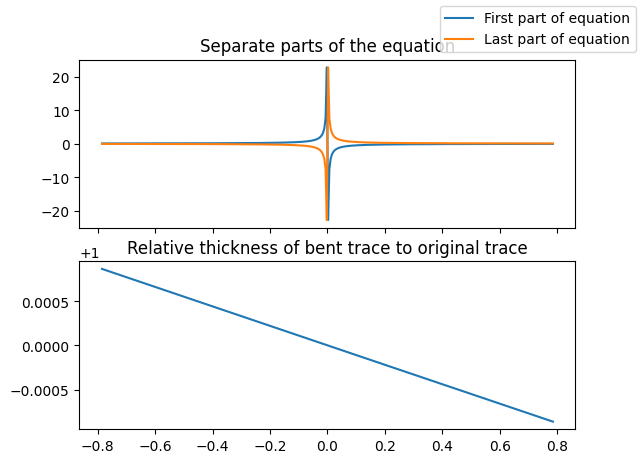

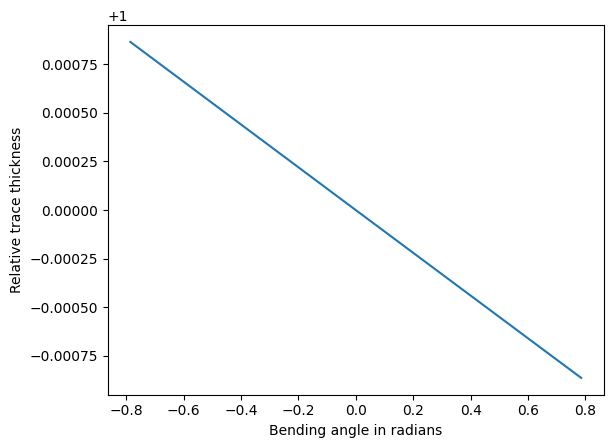

In [2]:
def first(
        angle: float,
        length: float,
        pcb_height: float
):
    return -(length/angle) - pcb_height/2

def last(
        angle: float,
        length: float,
        height: float,
        pcb_height: float
):
    under_sqrt = length**2/angle**2 + length*pcb_height/angle + pcb_height**2/4 +2*length*height/angle
    return np.sqrt(under_sqrt) * np.sign(angle)

def calc(
        angle: float | list[float],
        length: float=l_o,
        height: float=h_o,
        pcb_height: float=h_pcb,
        relative: bool=False
):
    """
    Calculates the height of a trace being bent on a bendable pcb.

    :param angle: single angle or array-like of angles
    :param length: trace length
    :param height: trace height
    :param pcb_height: pcb height
    :param relative: true to calculate new heights relative to original height; false to calculate new heights in absolute numbers
    :return: New trace height(s) for given parameters
    """
    res = first(angle, length, pcb_height) + last(angle, length, height, pcb_height)

    return res/height if relative else res

fig, axs = plt.subplots(2,1, sharex=True)
axs[0].plot(r, first(r, length=l_o, pcb_height=h_pcb), label="First part of equation")
axs[0].plot(r, last(r, length=l_o, height=h_o, pcb_height=h_pcb), label="Last part of equation")
axs[0].set_title("Separate parts of the equation")

axs[1].plot(r, calc(r, relative=True))
axs[1].set_title("Relative thickness of bent trace to original trace")
fig.legend()
#plt.title()
plt.show()

#plt.rcParams.update({'font.size': 16})
plt.plot(r, calc(r, relative=True))
plt.ylabel("Relative trace thickness")
plt.xlabel("Bending angle in radians")
plt.show()

In [3]:
class VDD(int, Enum):
    V5 = 5
    V33 = 3.3

def plot_voltage_levels(ink_res: float,
                        constant_res: int,
                        vdd: float,
                        in_mv: bool,
                        sensor_total_length: float=.2,
                        sensor_width: float = 0.01,
                        trace_width:float=1e-4,
                        trace_height:float=6e-6):
    height = calc(
        r,
        length=sensor_total_length,
        height=trace_height
    )

    sensor_res_sensing_direction    = ink_res * sensor_total_length / (trace_width * height)
    sensor_res_perpendicular        = ink_res * sensor_width / (trace_width * trace_height)

    # Add traces perpendicular to sensing direction, assume they are not affected by bending
    sensor_res = sensor_res_sensing_direction + sensor_res_perpendicular

    upper = sensor_res + constant_res
    lower = np.flip(upper)

    voltages = vdd*lower / (upper+lower)

    sensor_res_sensing_unbent = np.median(sensor_res_sensing_direction)

    display(f"Current flowing at 0°           : {vdd   /np.median(upper)*2*1000:10.4f}mA")
    display(f"Power used                      : {vdd**2/np.median(upper)*2*1000:10.4f}mW")
    display(f"Current flowing 200% elongation : {vdd/(sensor_res_sensing_unbent*2+sensor_res_perpendicular+constant_res)*2*1000:10.4f}mA")

    fig, axs = plt.subplots(2,1, sharex=True)

    ax = axs[0]
    ax.plot(r, sensor_res)
    ax.set_ylabel("Resistance in Ohm")
    ax.set_title("Single load cell resistance")

    ax = axs[1]
    ax.plot(r, voltages * 1000 if in_mv else voltages)
    ax.set_ylabel("Sensor voltage in " + ("mV" if in_mv else "V"))
    ax.set_xlabel("Bending angle in rad")
    ax.set_title("Sensor output voltage")

    plt.show()

    return voltages     # in V

def cut_for_voltage_range(data, voltage_range):
    return np.maximum(np.minimum(data, voltage_range), -voltage_range)

def plot_sensing_capabilities(voltage_widget: interactive, voltage_range: float, v_ref: float=2.5, resolution_bits: int=16):
    in_mv = voltage_widget.kwargs['in_mv']
    lsb_range = voltage_range/2**(resolution_bits-1)
    display(f"ADC LSB range: {lsb_range * 1000 if in_mv else lsb_range}" + ("mV" if in_mv else "V"))

    sense = cut_for_voltage_range(((voltage_widget.result-v_ref) // lsb_range) * lsb_range, voltage_range)
    fig, ax = plt.subplots()
    ax.plot(r, (voltage_widget.result-v_ref) * 1000 if in_mv else (voltage_widget.result-v_ref))
    ax.plot(r, sense * 1000 if in_mv else sense)#, ".", markersize=3)
    ax.set_ylabel("Sensed voltage in mV" if in_mv else "Sensed voltage in V")
    ax.set_xlabel("Bending angle in rad")
    plt.show()
    return

w1 = interactive(plot_voltage_levels,
                constant_res=(0,100000,100),
                in_mv=True,
                vdd=[("3V3", 3.3),("5V", 5)],
                ink_res=widgets.Dropdown(
                    options=[("SC1502",5e-3), ("FS0142", 6e-8)],
                    description="Ink:"
                ),
                sensor_total_length=(.01, .5, .01),
                sensor_width=(0,0.1,0.001),
                trace_width=fixed(1e-4),
                trace_height=widgets.FloatSlider(
                    min=6e-6,
                    max=12e-6,
                    step=1e-6,
                    description='Trace height:',
                    readout_format='.1e',
                ))
display(w1)

w2 = interactive(plot_sensing_capabilities, voltage_widget=fixed(w1), voltage_range=[0.02,1.75,.256,.512,1.024,2.048,4.096,6.144], v_ref=(0,5,.05), resolution_bits=(10,16,1))
display(w2)


interactive(children=(Dropdown(description='Ink:', options=(('SC1502', 0.005), ('FS0142', 6e-08)), value=0.005…

interactive(children=(Dropdown(description='voltage_range', options=(0.02, 1.75, 0.256, 0.512, 1.024, 2.048, 4…

'Current flowing at 0°           :     0.0026mA'

'Power used                      :     0.0087mW'

'Current flowing 200% elongation :     0.0016mA'

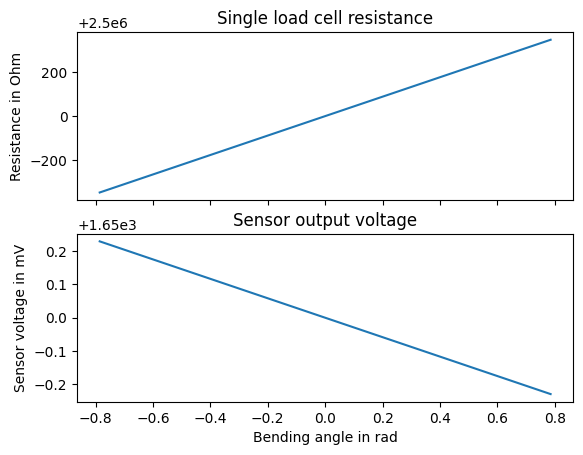

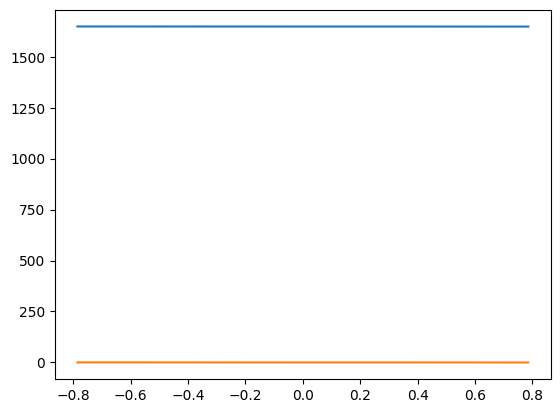

In [4]:
# ADC Comparison for LaTeX

in_mv = True
v_levels = plot_voltage_levels(
    ink_res=5e-3,
    constant_res=0,
    vdd=3.3,
    in_mv=in_mv,
    sensor_total_length=.2,
    sensor_width=0.1,
    trace_width=1e-4,
    trace_height=6e-6,
) # Taken from appendix values from thesis

v_ref = 3.3/2
voltage_range = 0.256
resolution_bits = 16
lsb_range = voltage_range/2**(resolution_bits-1)
sensed_voltages_ref = cut_for_voltage_range(((v_levels-v_ref) // lsb_range) * lsb_range, voltage_range)
sensed_voltages_no_ref = cut_for_voltage_range((v_levels // lsb_range) * lsb_range, voltage_range)

if in_mv:
    v_levels *= 1000
    sensed_voltages_ref *= 1000
    sensed_voltages_no_ref *= 1000

fig, ax = plt.subplots()
ax.plot(r, v_levels-v_ref)
ax.plot(r, sensed_voltages_ref)
#ax.plot(r, sensed_voltages_no_ref)
plt.show()


In [5]:
"""from matplotlib import cm


def calc(a, l):
    return -(l/a) - h_pcb/2 + np.sqrt(l**2/a**2 + l*h_pcb/a + h_pcb**2/4 +2*l*h_o/a) * np.sign(a)

plt.plot(r, np.fromiter((calc(a, 1) for a in r), np.float128, count=len(r)))
plt.show()

#print(lengths)
#print(r)
#print(len(lengths))
#print(len(r))
#print(grid[0].shape)
#print(grid[1].shape)

results = []
for outer_i in range(grid[0].shape[0]):
    results.append([])
    for inner_i in range(grid[0].shape[1]):
        res = calc(grid[1][outer_i][inner_i], grid[0][outer_i][inner_i])
        if res >=1:
            print(res, grid[1][outer_i][inner_i], grid[0][outer_i][inner_i])
        results[outer_i].append(res)

results = np.array(results)

#indices = list(np.ndindex(grid[0].shape))
#print(indices)

#it = (calc(grid[0][ix][iy], grid[1][ix][iy]) for (ix, iy) in indices)

#results = np.fromiter(it, np.float128, len(r)*len(lengths))
#print(results)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(grid[0], grid[1], results, cmap=cm.Blues)
#ax.set_zscale('log')
plt.show()"""
pass

In [6]:
"""def first2(a):
    return -h_pcb/2 + l_o/a

def last2(a):
    return np.sqrt(h_pcb**2/4 - h_pcb*l_o/a + l_o**2/a**2 - 2*l_o*h_o/a)

first2_dat = np.fromiter((first2(a) for a in r), np.float128, count=len(r))
last2_dat = np.fromiter((last2(a) for a in r), np.float128, count=len(r))
plt.plot(r, first2_dat)
plt.show()
plt.plot(r, last2_dat)
plt.show()
plt.plot(r, (first2_dat+last2_dat)/h_o)
plt.show()
plt.plot(r, (first2_dat-last2_dat)/h_o)
plt.show()
print(first2_dat-last2_dat)"""
pass